<center><h1> <font color="green"><u>Closed-Case Predictions ~ 19-nCoV</u></font> </h1></center>

<center><h3> <font color="#cc0000"><u>Closed Cases(%) out of Confirmed</u></font> </h3></center>

<h3> <font color="purple"><u>This section includes:</u></font> </h3>

> * Data Filtering <br />
> * Training & Testing datasets <br />
> * Prediction <br />
> * Visualization (Scatter Plots) <br />

<br />

## Creating Datasets

In [1]:
# setting the working directory
setwd("~/Documents/A-tracking-of-2019-nCoV/COVID-19/ready_to_use")

In [2]:
# Loading desired libraries
library(readr)
library(ggplot2)
library(stringr)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang



<hr />

In [3]:
all = read_csv('COVID-19/Mixed/countryWise_bulk_summary.csv')
world = read_csv('COVID-19/World/World_dataset_dateWise_summary.csv')

hubei = read_csv('COVID-19/Hubei/Hubei_dataset_dateWise_summary.csv')
cruise = read_csv('COVID-19/Cruise/Diamond_Princess_dataset_dateWise_summary.csv')

Parsed with column specification:
cols(
  Country = col_character(),
  Day = col_double(),
  Date = col_character(),
  Confirmed = col_double(),
  Deaths = col_double(),
  Recovered = col_double(),
  Active.Cases = col_double(),
  Closed.Cases = col_double()
)

Parsed with column specification:
cols(
  Location = col_character(),
  Day = col_double(),
  Date = col_character(),
  Confirmed = col_double(),
  Deaths = col_double(),
  Recovered = col_double(),
  Active.Cases = col_double(),
  Closed.Cases = col_double()
)

Parsed with column specification:
cols(
  State = col_character(),
  Day = col_double(),
  Date = col_character(),
  Confirmed = col_double(),
  Deaths = col_double(),
  Recovered = col_double(),
  Active.Cases = col_double(),
  Closed.Cases = col_double()
)

Parsed with column specification:
cols(
  State = col_character(),
  Day = col_double(),
  Date = col_character(),
  Confirmed = col_double(),
  Deaths = col_double(),
  Recovered = col_double(),
  Active.Cases = co

In [4]:
# country list
countries = matrix(levels(as.factor(all$Country)))

#head(countries, 10)

<br /> 
### Choosing desired Country/Region

In [5]:
# country i.e. to be used throughout the analysis
 rName = 'China' # without hubei

# rName = 'World'
# rName = 'Hubei'
# rName = 'Diamond Cruise'

# whole_china --->  'China' + hubei

<hr />

In [6]:
# filtering out desired country
region = all[which(str_detect(all$Country, rName)),]

# region = world
# region = hubei
# region = cruise[14:nrow(cruise),]

head(region)

Country,Day,Date,Confirmed,Deaths,Recovered,Active.Cases,Closed.Cases
China,1,22-01-2020,104,0,0,104,0
China,2,23-01-2020,199,1,2,196,3
China,3,24-01-2020,371,2,5,364,7
China,4,25-01-2020,645,2,7,636,9
China,5,26-01-2020,1017,4,7,1006,11
China,6,27-01-2020,1454,6,13,1435,19


<hr />

In [7]:
region=region[,c('Day','Confirmed','Closed.Cases')]
head(region, 10)

Day,Confirmed,Closed.Cases
1,104,0
2,199,3
3,371,7
4,645,9
5,1017,11
6,1454,19
7,1955,27
8,2533,40
9,3238,54
10,3996,82


In [8]:
# calculate the percent (using Confirmed cases as total)
percent <- function(dfName){
    get(dfName) -> df
    part <- NULL
    
    for(i in 1:nrow(df)) {
        val = df[i,"Closed.Cases"]
        Total = df[i,"Confirmed"]
        
        
        if(i == 1)
            if(val==0)
                part = 0
            else
                part = as.numeric((val*100)/Total)
        else
            if(val==0)
                part = c(part, 0)
            else
                part <- c(part, as.numeric((val*100)/Total))
    }
        
    return(part)
}

<hr />

In [9]:
# CASES -> percentage
region$'percent_active' = 100-percent("region")     # Active cases, out of every 100 Confirmed cases
region$'percent_closed' = percent("region") # Closed cases, out of every 100 Confirmed cases

In [10]:
head(region)

Day,Confirmed,Closed.Cases,percent_active,percent_closed
1,104,0,100.00000,0.000000
2,199,3,98.49246,1.507538
3,371,7,98.11321,1.886792
4,645,9,98.60465,1.395349
5,1017,11,98.91839,1.081613
6,1454,19,98.69326,1.306740


<br />* Dataset is ready

<hr /><br />

### Understanding the plot

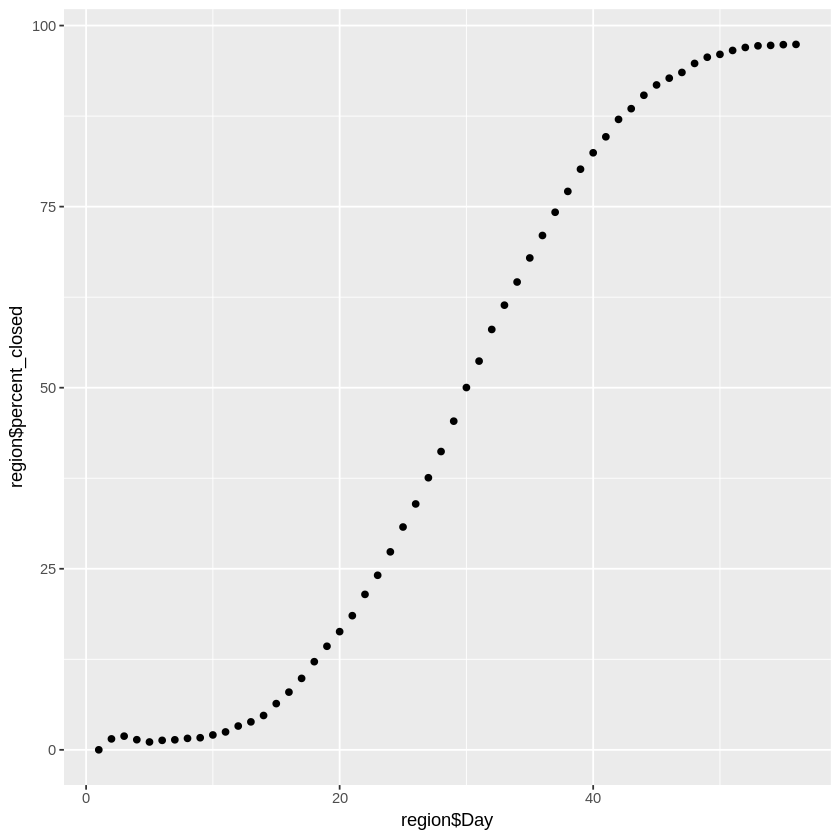

In [11]:
# Day vs %Active Cases
region.scatter.plot <- ggplot(region, aes(x = region$Day, y = region$percent_closed)) +
                        geom_point()
region.scatter.plot

In [12]:
tail(region)

Day,Confirmed,Closed.Cases,percent_active,percent_closed
51,13151,12699,3.437001,96.56300
52,13159,12761,3.024546,96.97545
53,13187,12818,2.798210,97.20179
54,13209,12847,2.740556,97.25944
55,13235,12886,2.636947,97.36305
56,13259,12914,2.602006,97.39799


<br /><hr /><br />

## Data-Analysis <br />

In [13]:
# loading plotting/machine learning
library(tidyverse)
library(caret)

# setting the theme
theme_set(theme_classic())

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ tibble  2.1.1     ✔ purrr   0.3.3
✔ tidyr   1.0.2     ✔ dplyr   0.8.3
✔ tibble  2.1.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




In [14]:
set.seed(20) # generages same set of random sample every time

training.samples <- region$Day %>%
  createDataPartition(p = 0.8, list = FALSE)

train.data  <- region[training.samples, ]
test.data <- region[-training.samples, ]

In [15]:
head(train.data, 3)
head(test.data, 3)

Day,Confirmed,Closed.Cases,percent_active,percent_closed
2,199,3,98.49246,1.507538
3,371,7,98.11321,1.886792
4,645,9,98.60465,1.395349


Day,Confirmed,Closed.Cases,percent_active,percent_closed
1,104,0,100.00000,0.000000
10,3996,82,97.94795,2.052052
21,11020,2041,81.47913,18.520871


`geom_smooth()` using method = 'loess' and formula 'y ~ x'



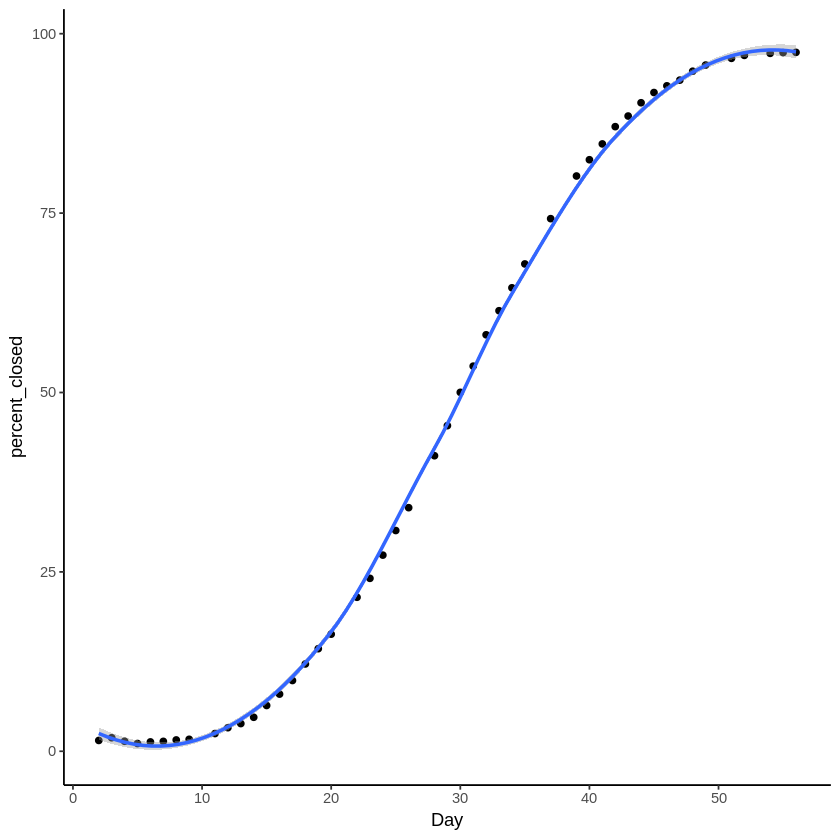

In [16]:
ggplot(train.data, aes(Day, percent_closed) ) +
  geom_point() +
  stat_smooth()

<br /><hr /><br />

## Regrassion

1. ### Linear regression

In [17]:
# y = x
# Build the model

# pridiction by linear model
fit = lm(Day ~ percent_closed, data = train.data)

In [18]:
# Predicting
predictions <- fit %>% predict(train.data)

In [19]:
# Model performance
data.frame(
  RMSE = RMSE(predictions, train.data$Day),
  R2 = R2(predictions, train.data$Day)
)

RMSE,R2
3.363763,0.9557099


<br />

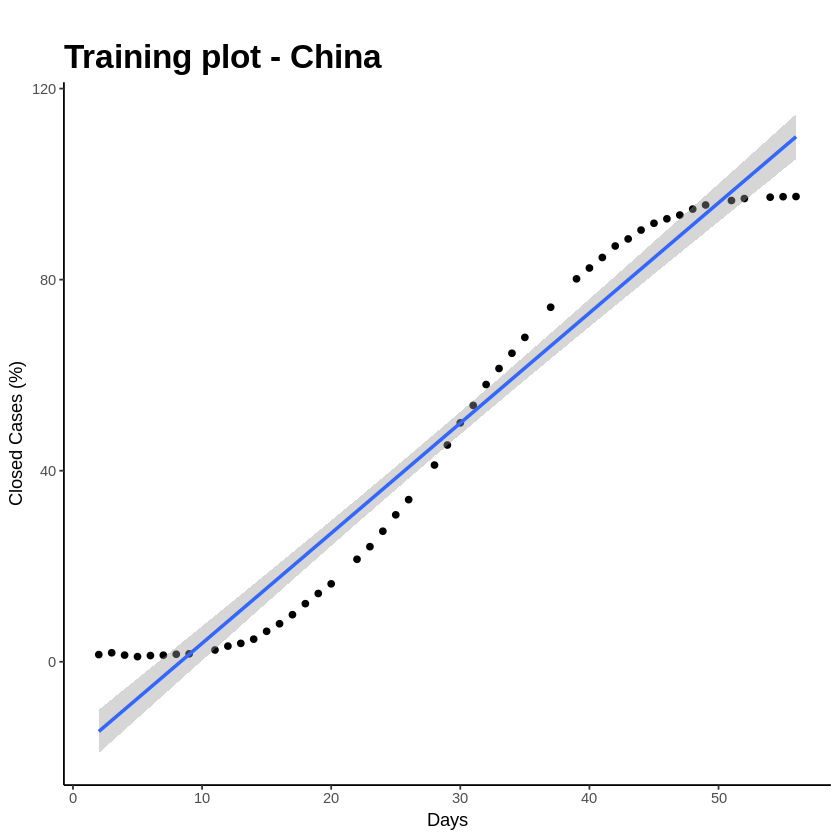

In [20]:
trainer <- ggplot(train.data, aes(Day, percent_closed) ) +
              geom_point() +
              stat_smooth(method = lm, formula = y ~ x) +   # linear function
  
              # decoration
              labs( x = "Days", y = "Closed Cases (%)", title = paste("\nTraining plot", rName, sep = " - ") ) +
              theme( plot.title = element_text(size = 20, face = "bold")) 
trainer

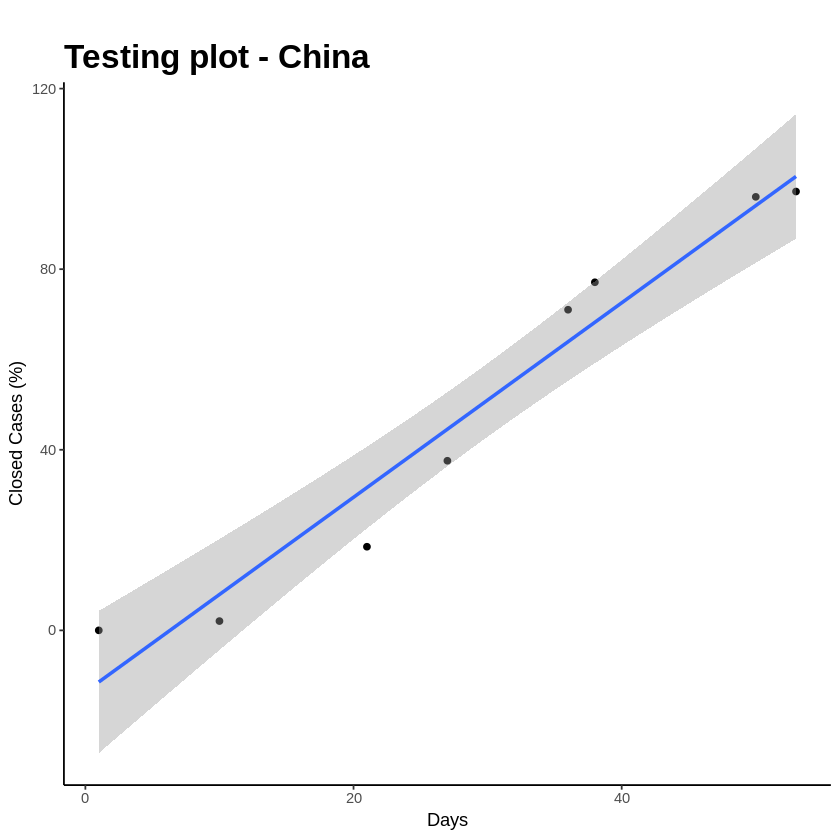

In [21]:
tester <- ggplot(test.data, aes(Day, percent_closed) ) +
              geom_point() +
              stat_smooth(method = lm, formula = y ~ x) +   # linear function
  
              # decoration
              labs( x = "Days", y = "Closed Cases (%)", title = paste("\nTesting plot", rName, sep = " - ") ) +
              theme( plot.title = element_text(size = 20, face = "bold")) 
tester

In [22]:

### can be TESTED in case of any problem in the ABOVE PLOT ###

#  # pridiction by linear model
#  pred <- predict(fit)   # fitting the model
#
#  plot(percent_closed ~ Day, data = test.data)     #  "data = train.data"    is also possible
#  lines(train.data$Day, y=pred, col = "blue")


<br />

In [23]:
trained = cbind( # Prediction for training data
            train.data[,c("Day", "percent_closed")],
            Pridicted_percent_closed = signif(predict(fit, train.data), 2)
          )

tested = cbind(  # Prediction for tested data
            test.data[,c("Day", "percent_closed")],
            Pridicted_percent_closed = signif(predict(fit, test.data), 2)
         )


tail(trained, 10)
tail(tested, 10)

,Day,percent_closed,Pridicted_percent_closed
39,45,91.80027,47
40,46,92.73504,48
41,47,93.52699,48
42,48,94.77015,48
43,49,95.62733,49
44,51,96.56300,49
45,52,96.97545,49
46,54,97.25944,50
47,55,97.36305,50
48,56,97.39799,50


Day,percent_closed,Pridicted_percent_closed
1,0.000000,9.2
10,2.052052,10.0
21,18.520871,17.0
27,37.565287,25.0
36,71.014716,39.0
38,77.101583,41.0
50,96.022209,49.0
53,97.201790,50.0


<br />

2. ### Polynomial regression

In [29]:
# y = x + I(x^2)...   ---->   a polynomial function
deg = 16        # degree of polynomial

# better and alternate way for line i.e. above
model = lm(percent_closed ~ poly(Day, deg, raw = TRUE), data = train.data)

In [30]:
#head(test.data)
#head(train.data)

In [31]:
predictions <- model %>% predict(train.data)

Warning message in predict.lm(., train.data):
“prediction from a rank-deficient fit may be misleading”


In [32]:
# Model performance
data.frame(
  RMSE = RMSE(predictions, train.data$Day),
  R2 = R2(predictions, train.data$Day)
)

RMSE,R2
28.55332,0.9557325


<br /><br />

Warning message in predict.lm(model, newdata = data.frame(x = xseq), se.fit = se, :
“prediction from a rank-deficient fit may be misleading”


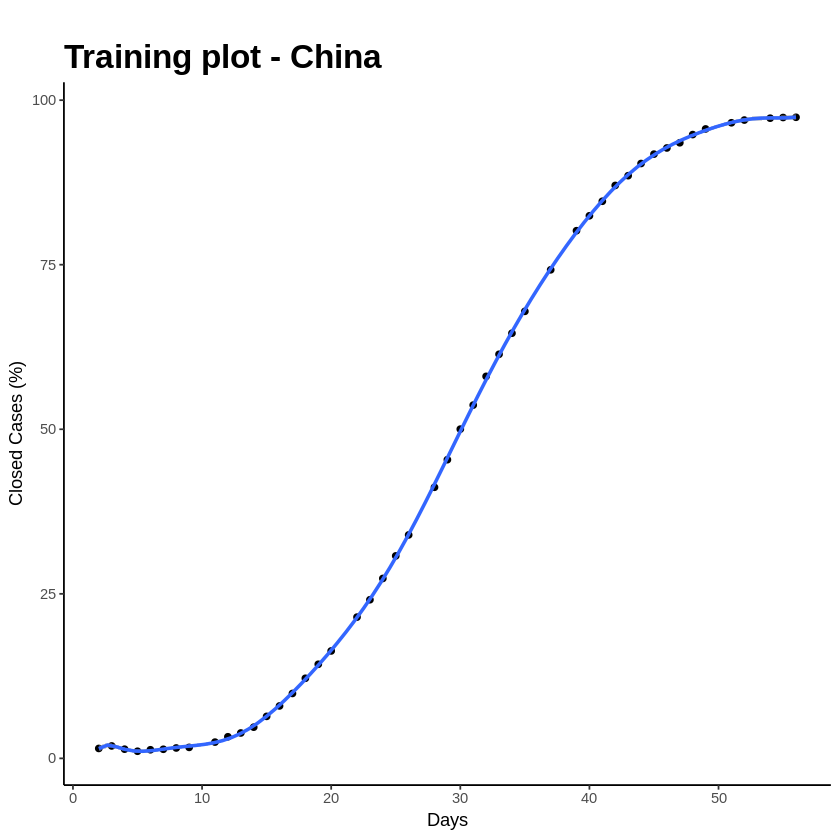

In [33]:
trainer <- ggplot(train.data, aes(Day, percent_closed) ) +
              geom_point() +
              stat_smooth(method = lm, formula = y ~ poly(x, deg, raw = TRUE)) +   # polynomial function
  
              # decoration
              labs( x = "Days", y = "Closed Cases (%)", title = paste("\nTraining plot", rName, sep = " - ") ) +
              theme( plot.title = element_text(size = 20, face = "bold")) 
trainer

Warning message in predict.lm(model, newdata = data.frame(x = xseq), se.fit = se, :
“prediction from a rank-deficient fit may be misleading”
Warning message in qt((1 - level)/2, df):
“NaNs produced”


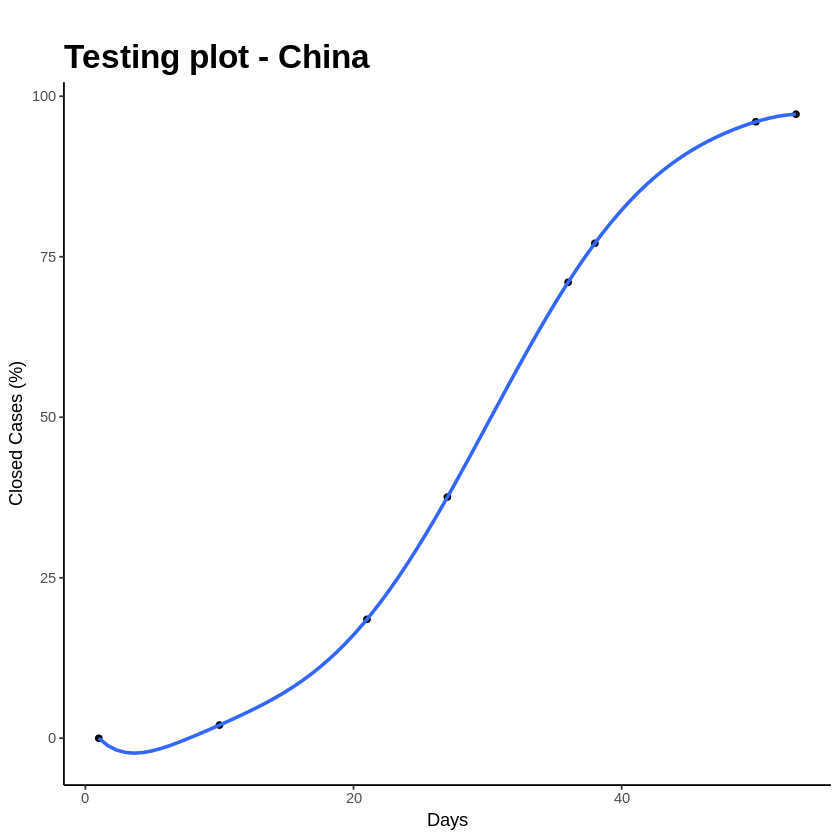

In [34]:
tester <- ggplot(test.data, aes(Day, percent_closed) ) +
              geom_point() +
              stat_smooth(method = lm, formula = y ~ poly(x, deg, raw = TRUE)) +   # polynomial function
  
              # decoration
              labs( x = "Days", y = "Closed Cases (%)", title = paste("\nTesting plot", rName, sep = " - ") ) +
              theme( plot.title = element_text(size = 20, face = "bold")) 
tester

In [35]:

### can be TESTED in case of any problem in the ABOVE PLOT ###

#  # pridiction by polynomial model
#  pred <- predict(model)   # fitting the model
#
#  plot(percent_closed ~ Day, data = test.data)     #  "data = train.data"    is also possible
#  lines(train.data$Day, y=pred, col = "blue")


<br /><br />

In [46]:
trained = cbind( # Prediction for training data
            train.data[,c("Day", "percent_closed")],
            Pridicted_percent_closed = predict(model, train.data)
          )

tested = cbind(  # Prediction for tested data
            test.data[,c("Day", "percent_closed")],
            Pridicted_percent_closed = predict(model, test.data)
         )


tail(trained, 10)
tail(tested, 10)

Warning message in predict.lm(model, train.data):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(model, test.data):
“prediction from a rank-deficient fit may be misleading”


,Day,percent_closed,Pridicted_percent_closed
39,45,91.80027,91.67926
40,46,92.73504,92.84432
41,47,93.52699,93.82970
42,48,94.77015,94.67548
43,49,95.62733,95.41484
44,51,96.56300,96.60280
45,52,96.97545,97.00464
46,54,97.25944,97.30248
47,55,97.36305,97.30195
48,56,97.39799,97.41678


Day,percent_closed,Pridicted_percent_closed
1,0.000000,-3.973035
10,2.052052,2.078292
21,18.520871,18.827928
27,37.565287,37.770402
36,71.014716,71.384173
38,77.101583,77.255151
50,96.022209,96.061530
53,97.201790,97.234710


<br /><hr /><br />

## Predictions

In [47]:
test_Miscellaneous = data.frame(
                        Day = NaN,
                        Confirmed = NaN,
                        Closed.Cases = NaN,
                        percent_active = NaN,
                        percent_closed = NaN
                     )

In [51]:
# 15th March ---> day 54
dNo = 57    # get the day no. to pridict

test_Miscellaneous$'Day' = dNo

<br /> 
1. #### By Linear Model

In [52]:
# modeling variable  --->  fit
Prediction = cbind(
                test_Miscellaneous[,c("Day", "percent_closed")],
                percent_pridicted = signif(predict(fit, test_Miscellaneous), 2)
             )
Prediction

Day,percent_closed,percent_pridicted
57,NaN,NaN


<br /> 
2. #### By Polynomial Model

In [53]:
# modeling variable  --->  model
Prediction = cbind(
                test_Miscellaneous[,c("Day", "percent_closed")],
                percent_pridicted = predict(model, test_Miscellaneous)
             )
Prediction

Warning message in predict.lm(model, test_Miscellaneous):
“prediction from a rank-deficient fit may be misleading”


Day,percent_closed,percent_pridicted
57,NaN,97.80455


<hr /> <br />

## for day 57 (18th march, in chaina) :
> 97.80455 cases will be resolved <br />
> 02.195447 cases will still be active